<a href="https://colab.research.google.com/github/Mohit501/MNIST-image-Reconstruction-using-AutoEncoder/blob/main/Reconstruction_of_MNIST_images_using_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing required libraries**

In [1]:
from tensorflow import keras
from keras.layers import Dense,Input,Conv2D,Flatten,Conv2DTranspose,Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.utils import plot_model
from keras import backend as k
import numpy as np
import matplotlib.pyplot as plt


# **Loading Images**

In [2]:
(x_train,_),(x_test,_) = mnist.load_data()

# **Pre-processing**


In [3]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1,image_size,image_size,1])
x_test = np.reshape(x_test,[-1,image_size,image_size,1])
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255


In [4]:
input_shape = (image_size,image_size,1)
layer_filters = [32,64]

# **Building AutoEncoder Model**

## 1. Encoder

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          8256      
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 58,608
Trainable params: 58,608
Non-trainable params: 0
_________________________________________________________________


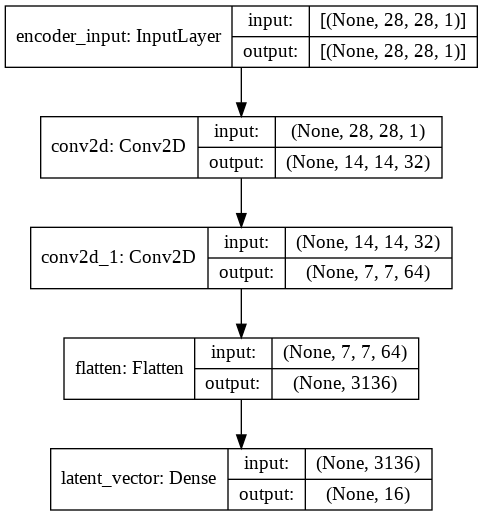

In [5]:
inputs = Input(shape=input_shape,name = 'encoder_input')
x = inputs
for filters in layer_filters:
  x = Conv2D(filters=filters,kernel_size = 2,activation='relu',padding = 'same',strides = 2)(x)

shape = k.int_shape(x)
x = Flatten()(x)
latent = Dense(16,name = 'latent_vector')(x)

encoder = Model(inputs,latent,name = 'encoder')
encoder.summary()
plot_model(encoder,show_shapes=True)

# 2. Decoder

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        16448     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        8224      
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         129       
Total params: 78,113
Trainable params: 78,113
Non-trainable params: 0
_______________________________________________________

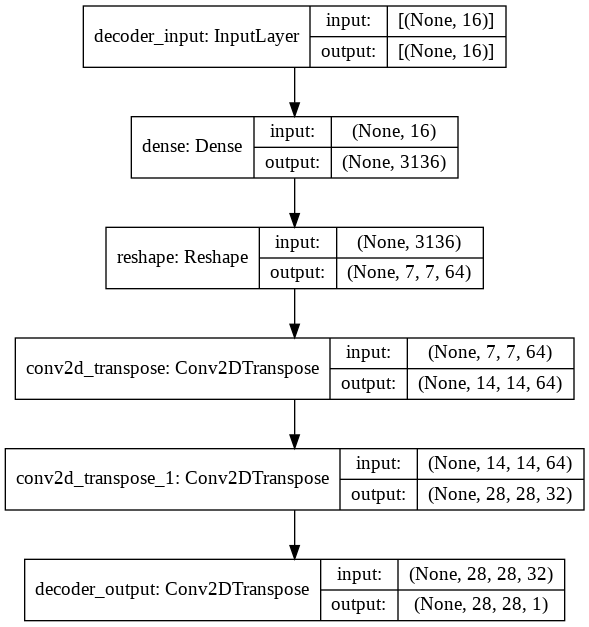

In [6]:
latent_inputs = Input(shape = (16,),name = 'decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1],shape[2],shape[3]))(x)

for filters in layer_filters[::-1]:
  x = Conv2DTranspose(filters=filters,kernel_size=2,activation = 'relu',strides=2,padding='same')(x)

outputs = Conv2DTranspose(filters=1,kernel_size=2,activation='sigmoid',padding='same',name = 'decoder_output')(x)

decoder = Model(latent_inputs,outputs,name = 'decoder')
decoder.summary()
plot_model(decoder,show_shapes=True)
    
                

# AutoEncoder = Encoder+Decoder

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                58608     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         78113     
Total params: 136,721
Trainable params: 136,721
Non-trainable params: 0
_________________________________________________________________


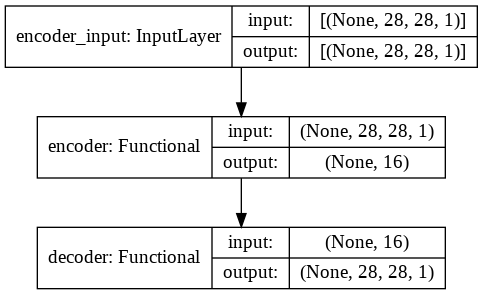

In [7]:
autoencoder = Model(inputs,decoder(encoder(inputs)),name = 'autoencoder')
autoencoder.summary()
plot_model(autoencoder,show_shapes=True)

In [8]:
autoencoder.compile(loss = 'mean_squared_error',optimizer='adam')

In [9]:
autoencoder.fit(x_train,x_train,epochs=2,batch_size = 32)

Epoch 1/2
1875/1875 [==============================] - 8s 3ms/step - loss: 0.0465
Epoch 2/2
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0121


In [10]:
x_decoded = autoencoder.predict(x_test)

# **Visualizing Reconstructed images**

In [11]:
imgs = np.concatenate([x_test[:8],x_decoded[:8]])
imgs = imgs.reshape((4,4,image_size,image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])

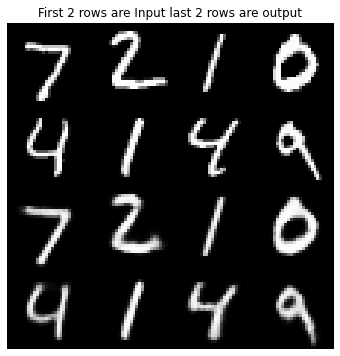

In [12]:
plt.figure(figsize = (25,6))
plt.axis('off');
plt.title('First 2 rows are Input last 2 rows are output');
plt.imshow(imgs,interpolation='none',cmap='gray');